# Recurrent Neural Network

## Genesis Quiles-Galarza

The Lotka-Volterra equations are two coupled first-order nonlinear differential equations that are used to characterize the dynamics of biological systems in which a predator population and a prey population interact. The two populations develop over time according to the equations:
$$\dot x = x(\alpha -\beta y)$$

$$\dot y = -y(\gamma - \sigma x)$$

where $x$ is the number of prey (for e.g., rabbits), $y$ is the number of predators (e.g. foxes), and $\dot x$ and $\dot y$ represent the growth rates (the rates of change over time) of the two populations. The values $\alpha$, $\beta$, $\gamma$, $\sigma$ are parameters (constants) that characterize different aspects of the two populations.

(i) We will create a time-series data-set using SciPy to integrate this system in the interval $t \in [0, 60]$ using 2,000 time sets for ($\alpha$, $\beta$, $\gamma$, $\sigma$) = (1.0, 0.1, 1.5, 0.75) using an initial condition of $x(t=0) = 10.0$, $y(t=0) = 5.0$.

(ii) We will implement a Long Short-Term Memory (LSTM) recurrent neural network with 8 lags, one hidden layer with 20 neurons, and a hyperbolic tangent activation function. We will train the network using the first 2/3 of your dataset for 20,000 stochastic gradient descent steps using the Adam optimizer with a learning rate of $10^{-3}$ and a mini-batch size of 128. We're going to use the trained model to perfrom one-step-ahead predictions until the final time $T = 60$, and compare them against the true data. Finally, we'll plot the predicted and exact signals, and report their discrepancy within the test interval in the relative $\mathbb{L}_2$ norm. 

In [25]:
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
import pylab as p
import scipy
from scipy import integrate
from pyDOE import *
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import cv2
import os
from PIL import Image

In [3]:
# This code is originally sourced and has been modified from Paris Perdikaris's
# Recurrent Neural Network code posted on Github and found at the following link:
# https://github.com/PredictiveIntelligenceLab/ENM531/blob/master/Week7/models_torch.py

class RNN:
    # Initialize the class
    def __init__(self, X, Y, hidden_dim):
        # Check if there is a GPU available
        if torch.cuda.is_available() == True:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor
        # X has the form lags x data x dim
        # Y has the form data x dim
        # Define PyTorch variables
        X = torch.from_numpy(X).type(self.dtype)
        Y = torch.from_numpy(Y).type(self.dtype)
        self.X = Variable(X, requires_grad=False)
        self.Y = Variable(Y, requires_grad=False)
        self.X_dim = X.shape[-1]
        self.Y_dim = Y.shape[-1]
        self.hidden_dim = hidden_dim
        self.lags = X.shape[0]
        # Initialize network weights and biases        
        self.Uo, self.bo, self.Wo, self.V, self.c = self.initialize_RNN()
        self.Us, self.bs, self.Ws = self.Uo, self.bo, self.Wo
        self.Ui, self.bi, self.Wi = self.Uo, self.bo, self.Wo
        self.Uf, self.bf, self.Wf = self.Uo, self.bo, self.Wo
        self.parameters = [self.Uo, self.bo, self.V, self.c, self.Wo,self.Us, self.bs, self.Ws,self.Ui, self.bi, self.Wi,self.Uf, self.bf, self.Wf]
        # Store loss values
        self.training_loss = []
        # Define optimizer
        self.optimizer = torch.optim.Adam(self.parameters, lr=1e-3)
    
    
    # Initialize network weights and biases using Xavier initialization
    def initialize_RNN(self):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
            return Variable(xavier_stddev*torch.randn(in_dim, out_dim).type(self.dtype), requires_grad=True)
        U = xavier_init(size=[self.X_dim, self.hidden_dim])
        b = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True) #Variable? What does this do?
        W = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        V = xavier_init(size=[self.hidden_dim, self.Y_dim])
        c = Variable(torch.zeros(1,self.Y_dim).type(self.dtype), requires_grad=True)
        return U, b, W, V, c
       
           
    # Evaluates the forward pass, use LSTM model.
    def forward_pass(self, X):
        H = torch.zeros(X.shape[1], self.hidden_dim).type(self.dtype)
        self.S = torch.zeros(H.shape).type(self.dtype)
        for i in range(0, self.lags):
            f = torch.sigmoid(torch.matmul(H,self.Wf) + torch.matmul(X[i,:,:],self.Uf) + self.bf) #forget gate
            q = torch.sigmoid(torch.matmul(H,self.Wi) + torch.matmul(X[i,:,:],self.Ui) + self.bi) #idk some other gate
            S_squig = torch.tanh(torch.matmul(H,self.Ws) + torch.matmul(X[i,:,:],self.Us) + self.bs)
            S = f*self.S + q*S_squig
            O = torch.sigmoid(torch.matmul(H,self.Wo) + torch.matmul(X[i,:,:],self.Uo) + self.bo)
            H = O*torch.tanh(S)
            self.S = S
        H = torch.matmul(H,self.V) + self.c
        return H
    
    # Computes the mean square error loss
    def compute_loss(self, X, Y):
        loss = torch.mean((Y - self.forward_pass(X))**2)
        return loss
    
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, y, N_batch):
        N = X.shape[1]
        idx = torch.randperm(N)[0:N_batch]
        X_batch = X[:,idx,:]
        y_batch = y[idx,:]        
        return X_batch, y_batch
    
    # Trains the model by minimizing the MSE lossb
    def train(self, nIter = 20000, batch_size = 128,verbose = True):
        for i in range(nIter):
            X_batch, Y_batch = self.fetch_minibatch(self.X, self.Y, batch_size)
            loss = self.compute_loss(X_batch, Y_batch)
            self.training_loss.append(loss)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            if verbose is True:
                if i % 1000 == 0:
                    print("Iteration: {} | Loss: {}".format(i, loss))
                    
    # Evaluates predictions at test points    
    def predict(self, X_star):
        X_star = torch.from_numpy(X_star).type(self.dtype)
        y_star = self.forward_pass(X_star)
        y_star = y_star.cpu().data.numpy()
        return y_star
    


In [8]:
# This code is originally sourced and has been modified from Paris Perdikaris's
# Recurrent Neural Network code posted on Github and found at the following link:
# https://github.com/PredictiveIntelligenceLab/ENM531/blob/master/Week7/example_RNN.py

np.random.seed(1234)
torch.manual_seed(1234)

def create_dataset(data, lags):
    N = len(data)-lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    for i in range(0,N):
        X[:,i,:] = data[i:(i+lags), :]
        Y[i,:] = data[i + lags, :]
    X_0 = np.copy(X)
    Y_0 = np.copy(Y)
    X[:,:,0] = (X[:,:,0] - np.mean(X[:,:,0]))/np.std(X[:,:,0])
    X[:,:,1] = (X[:,:,1] - np.mean(X[:,:,1]))/np.std(X[:,:,1])
    Y[:,0] = (Y[:,0] - np.mean(Y[:,0]))/np.std(Y[:,0])
    Y[:,1] = (Y[:,1] - np.mean(Y[:,1]))/np.std(Y[:,1])
    return X, Y, X_0, Y_0
    
# generate the dataset
def dX_dt(X,t=0):
    X = array([ alpha*X[0] - beta*X[0]*X[1] ,
                  -gamma*X[1] + sigma*X[0]*X[1] ])
    return X

alpha = 1.0
beta = 0.1
gamma = 1.5
sigma = 0.75
t = linspace(0,60,2000)
X0= array([10.0, 5.0]) #initial conditions
dataset = integrate.odeint(dX_dt, X0, t)

# Use 2/3 of all data as training Data
train_size = int(len(dataset) * (2.0/3.0))
train = dataset[0:train_size,:]
    
# reshape X and Y
# X has the form lags x data x dim
# Y has the form data x dim
lags = 8
X, Y, X_0, Y_0 = create_dataset(train, lags)
#test = dataset[:, :]
#X_test, Y_test = create_dataset(test, lags)
    
# Model creation
hidden_dim = 20
model = RNN(X, Y, hidden_dim)
model.train()



Iteration: 0 | Loss: 1.1905584335327148
Iteration: 1000 | Loss: 0.00027628816314972937
Iteration: 2000 | Loss: 0.00021781562827527523
Iteration: 3000 | Loss: 0.00011553323565749452
Iteration: 4000 | Loss: 0.0003632298030424863
Iteration: 5000 | Loss: 0.00014885806012898684
Iteration: 6000 | Loss: 0.00015765870921313763
Iteration: 7000 | Loss: 0.00021998834563419223
Iteration: 8000 | Loss: 7.433841528836638e-05
Iteration: 9000 | Loss: 8.695736323716119e-05
Iteration: 10000 | Loss: 0.00021693002781830728
Iteration: 11000 | Loss: 7.90583944763057e-05
Iteration: 12000 | Loss: 2.5806124540395103e-05
Iteration: 13000 | Loss: 6.120307079982013e-05
Iteration: 14000 | Loss: 3.2798503525555134e-05
Iteration: 15000 | Loss: 0.0002623152395244688
Iteration: 16000 | Loss: 8.802588854450732e-05
Iteration: 17000 | Loss: 2.1748397557530552e-05
Iteration: 18000 | Loss: 4.199822433292866e-05
Iteration: 19000 | Loss: 2.89431081910152e-05


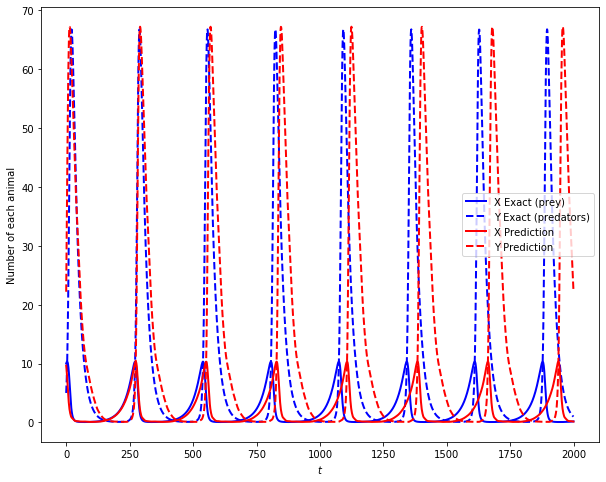

The L2 norm of the model was found to be: [0.06944845 0.48457345] for X and Y, respectively.


In [9]:
# One step ahead prediction
#pred = np.zeros((len(dataset)-lags, Y_test.shape[-1]))
pred = np.zeros((len(dataset), Y.shape[-1]))
X_tmp =  np.copy(X[:,0:1,:]) #x_temp is shape lags x 1 x dim
#for i in range(0, len(dataset)-lags):
for i in range(0, len(dataset)):
    pred[i] = model.predict(X_tmp) #make a prediction using x_tmp
    X_tmp[:-1,:,:] = X_tmp[1:,:,:] #shifts values down by 1
    X_tmp[-1,:,:] = pred[i] #replaces the values with the predictions
#pred needs to be unnormalized now.
pred[:,0] = pred[:,0]*np.std(Y_0[:,0])+np.mean(Y_0[:,0])
pred[:,1] = pred[:,1]*np.std(Y_0[:,1])+np.mean(Y_0[:,1])

#L2 = np.linalg.norm(pred - dataset[lags:], ord=2, axis=0) / pred.shape[0]
L2 = np.linalg.norm(pred - dataset, ord=2, axis=0) / pred.shape[0]

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(dataset[:,0], 'b-', linewidth = 2, label = "X Exact (prey)")
ax.plot(dataset[:,1], 'b--', linewidth = 2, label = "Y Exact (predators)")
ax.plot(pred[:,0], 'r-', linewidth = 2, label = "X Prediction")
ax.plot(pred[:,1], 'r--', linewidth = 2, label = "Y Prediction")
ax.set_xlabel('$t$')
ax.set_ylabel('Number of each animal')
ax.legend()
plt.show()

print('The L2 norm of the model was found to be:',L2,'for X and Y, respectively.')

In the plot above, the prediction is very close but for some reason the x-axis is shifted slightly more as it cycles through the data. This may be due to the nature of the one-step prediction, and possibly may be affected by the random seed given to the program.